# Deep Learning from the Foundations

In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Retrieve Data

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [3]:
from urllib.request import urlretrieve
if not path_gz.exists(): 
    urlretrieve(MNIST_URL, path_gz)

In [4]:
with gzip.open(path_gz, 'rb') as f: 
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

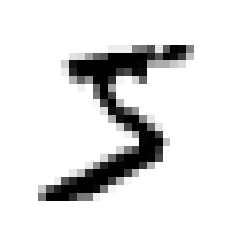

In [5]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plot_digit(x_train[0])

### Creat "is equal" test function

In [6]:
import operator

def test(a,b,comp,operator=None):
    assert comp(a,b),f"{operator}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

- MNIST has 10 digits and each digit has 784 pixels
- Require random initialisation of weights with shape `(784,10)`
- Require bias vector of length 10

In [7]:
import torch
from torch import tensor

w = torch.randn(784,10)
b = torch.zeros(10)

### Create a matrix multiplication function and optimize performance

In [8]:
def matmul(x,y):
    xr,xc = x.shape # number of rows and number of columns
    yr,yc = y.shape
    assert xc==yr # ensure matrices mathematically allowed to be multiplied
    z = torch.zeros(xr, yc) # initialise matrix results
    for i in range(xr):
        for j in range(yc):
            for k in range(yr):
                z[i,j] += x[i,k] * y[k,j] # calculate dot product
    return z

Test performance of `matmul`

In [9]:
a = x_train[:5]
a = torch.from_numpy(a)
b = w

%time result = matmul(a, b)

CPU times: user 646 ms, sys: 1 ms, total: 647 ms
Wall time: 647 ms


- Pytorch tensors support broadcasting like numpy arrays
- Broadcasting should significantly improve `matmul`'s efficiency
- Implement `matmul` with broadcasting and test performance

In [10]:
def matmul(x,y):
    xr,xc = x.shape 
    yr,yc = y.shape
    assert xc==yr 
    z = torch.zeros(xr, yc) 
    for i in range(xr):
        z[i] = (x[i].unsqueeze(-1) * y).sum(dim=0) # unsqueeze is used to convert a 1 D tensor into a 2 D tensor
    return z

In [11]:
%time result = matmul(a, b)

CPU times: user 1.25 ms, sys: 0 ns, total: 1.25 ms
Wall time: 3.38 ms


- Significantly faster wall time, over 100 times as fast
- Implement `matmul` with [Einstein summation](https://en.wikipedia.org/wiki/Einstein_notation)
- Use `einsum` with `matmul` and test performance

In [12]:
def matmul(x,y): 
    return torch.einsum('ik,kj->ij', x, y)

In [13]:
%time result = matmul(a, b)

CPU times: user 1.03 ms, sys: 1.01 ms, total: 2.04 ms
Wall time: 13.4 ms


- `einsum` does little for performance but significantly reduces the amount of code
- Pytorch has an implementation of matrix multiplication

In [14]:
%time result_pytorch = a@b

CPU times: user 697 µs, sys: 0 ns, total: 697 µs
Wall time: 1.6 ms


In [15]:
test_eq = (result, result_pytorch)

### Forward and backward pass
- Require ReLU and random weight initialisation for the forward pass
- Data needs to be normalised

In [16]:
# subtract the mean and divide by the standard deviation
def normalise(x, m, s):
    return (x-m)/s

In [17]:
train_mean = x_train.mean()
train_std = x_train.std()

In [18]:
# normalise training and validation data with the training metrics to keep them on the same scale
x_train = normalise(x_train, train_mean, train_std)
x_valid = normalise(x_valid, train_mean, train_std)

In [19]:
n,m = x_train.shape # size of training set
c = y_train.max()+1 # number of activations

In [20]:
n,m,c

(50000, 784, 10)

In [21]:
# num hidden
num_hidden = 50

- Standard [xavier initialisation](https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/)
- Kaiming He initialisation prevents the vanishing and exploding gradient problem
- Dividing by `math.sqrt` gives a mean close to 0 and a standard deviation of close to 1

In [22]:
w1 = torch.randn(m,num_hidden)/math.sqrt(m)
b1 = torch.zeros(num_hidden)
w2 = torch.randn(num_hidden,1)/math.sqrt(num_hidden) # only one output layer for now
b2 = torch.zeros(1) # only one output layer for now

In [23]:
# should be close to 0 and 1
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

In [24]:
def linear(x, w, b):
    return x@w + b

In [25]:
test_lin = linear(torch.from_numpy(x_train), w1, b1)

In [26]:
# should be close to 0 and 1 because of Xavier initialisation
test_lin.mean(), test_lin.std()

(tensor(0.0331), tensor(1.0207))

Implement ReLU

In [27]:
def relu(x):
    return x.clamp_min(0.)

In [28]:
test_relu = relu(test_lin)

- The way ReLU works, `x.clamp_min(0)`, means that all we lose a significant amount of data (negatives become 0), and so mean and standard deviation will not be close to 0 and 1
- The standard deviation is decreasing, and will continue to decrease with each layer, vanishing gradient problem
- Kaiming He initialisation fixes this problem

In [29]:
test_relu.mean(), test_relu.std()

(tensor(0.4183), tensor(0.6131))

In [30]:
w1 = torch.randn(m,num_hidden) * math.sqrt(2/m)

In [31]:
w1.mean(), w1.std()

(tensor(4.3644e-05), tensor(0.0506))

In [32]:
test_kaiming = relu(linear(torch.from_numpy(x_train), w1, b1))
test_kaiming.mean(), test_kaiming.std()

(tensor(0.5742), tensor(0.8883))

- Standard deviation is higher, but mean is still far from zero 
- On average a 0 mean passed through ReLU will have a mean of 0.5

In [33]:
def relu(x):
    return x.clamp_min(0.) - 0.5

In [34]:
test_new_relu = relu(linear(torch.from_numpy(x_train), w1, b1))
test_new_relu.mean(), test_new_relu.std()

(tensor(0.0742), tensor(0.8883))

Run the forward pass

In [35]:
def forward(x):
    l1 = linear(x, w1, b1)
    l2 = relu(l1)
    l3 = linear(l2, w2, b2)
    return l3

In [36]:
%time predictions = forward(torch.from_numpy(x_train))

CPU times: user 95.2 ms, sys: 17.9 ms, total: 113 ms
Wall time: 59.9 ms


In [37]:
predictions.shape

torch.Size([50000, 1])

Use mean squared error to calculate loss

In [38]:
def mse(x,y):
    return (x.squeeze(-1) - y).pow(2).mean()

In [39]:
mse(predictions, y_train)

tensor(28.8247, dtype=torch.float64)

### Backward pass and calculate gradients
- Backward pass is essentially the reverse of the forward pass, x -> Linear -> ReLU -> Linear -> MSE -> y
- This can also be thought as, y = MSE(Linear(ReLU(Linear(x)))), since the forward layer is a combination of functions
- The backward pass involves calculating the chain rule derivative of each function
- Gradient of the loss is therefore the chain rule of the entire combination
- Need to store gradients of each function and multiply at the end
- Store gradients in the `.g` attribute

In [40]:
def mse_grad(x, y): 
    x.g = 2. * (x.squeeze() - y).unsqueeze(-1) / x.shape[0]

In [41]:
def relu_grad(x, y):
    x.g = (x>0).float() * y.g

In [42]:
def lin_grad(x, y, w, b):
    # gradient is output multiplied by the matrix transpose
    x.g = y.g @ w.t()
    w.g = (x.unsqueeze(-1) * y.g.unsqueeze(1)).sum(0)
    b.g = y.g.sum(0)     

Model with forward and backward pass (backward pass calls the gradient of each consecutive function)

In [43]:
def forward_and_backward(x, y):
    # forward 
    l1 = x @ w1 + b1
    l2 = relu(l1)
    output = l2 @ w2 + b2
    loss = mse(output, y)
    
    # backward
    mse_grad(output, y)
    lin_grad(l2, output, w2, b2)
    relu_grad(l1, l2)
    lin_grad(x, l1, w1, b1)
    
    return loss

In [44]:
%time loss = forward_and_backward(torch.from_numpy(x_train), torch.from_numpy(y_train))

CPU times: user 3.86 s, sys: 7.31 s, total: 11.2 s
Wall time: 5.84 s


- This is a forward and backward pass representing one epoch
- Code can be refactored with layers as classes, like the PyTorch API
- Implemented above is a neural net with one epoch

### Compare with Convolution with `nn.Conv2d`
- Convolutions expect square matrices

In [45]:
x_train = torch.from_numpy(x_train).view(-1,1,28,28)
x_valid = torch.from_numpy(x_valid).view(-1,1,28,28)

In [46]:
n,*_ = x_train.shape
c = y_train.max()+1
nh = 32

In [47]:
from torch.nn import Conv2d 
l1 = Conv2d(1, nh, 5)

In [48]:
x = x_valid[:100]
x.shape

torch.Size([100, 1, 28, 28])

In [49]:
def stats(x):
    return x.mean(), x.std()

In [50]:
l1

Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))

In [51]:
l1.weight.shape

torch.Size([32, 1, 5, 5])

In [52]:
l1.bias.shape

torch.Size([32])

In [53]:
stats(l1.weight)

(tensor(-0.0071, grad_fn=<MeanBackward0>),
 tensor(0.1170, grad_fn=<StdBackward0>))

In [54]:
stats(l1.bias)

(tensor(0.0492, grad_fn=<MeanBackward0>),
 tensor(0.1114, grad_fn=<StdBackward0>))

In [55]:
m = l1(x)

In [56]:
# ideally mean should equal 0 and standard deviation should equal 1
stats(m)

(tensor(0.0318, grad_fn=<MeanBackward0>),
 tensor(0.6957, grad_fn=<StdBackward0>))

Initialise with Kaiming normal, which is mainly used for a leaky relu

In [57]:
from torch.nn.init import kaiming_normal_
kaiming_normal_(l1.weight, a=1.)
stats(l1(x))

(tensor(0.0524, grad_fn=<MeanBackward0>),
 tensor(0.9743, grad_fn=<StdBackward0>))

In [58]:
import torch.nn.functional as F

In [59]:
def leaky_relu(x, a=0.):
    return F.leaky_relu(l1(x),a)

%time t = leaky_relu(x_valid)

CPU times: user 734 ms, sys: 1.23 s, total: 1.96 s
Wall time: 1e+03 ms


In [60]:
kaiming_normal_(l1.weight, a=0)
stats(leaky_relu(x))

(tensor(0.5286, grad_fn=<MeanBackward0>),
 tensor(0.9700, grad_fn=<StdBackward0>))

In [61]:
l1 = Conv2d(1, nh, 5)
stats(leaky_relu(x))

(tensor(0.1989, grad_fn=<MeanBackward0>),
 tensor(0.3830, grad_fn=<StdBackward0>))

In [62]:
l1.weight.shape

torch.Size([32, 1, 5, 5])

In [63]:
l1.weight[0,0].numel()

25

- Receptive field size is the number of elements in that particular kernel
- Grab a set of elements from a kernel to calculate the number of elements

In [64]:
receptive_fs = l1.weight[0,0].numel()

- Number of filters out
- Number of filters in

In [65]:
nfo, nfi, *_ = l1.weight.shape

In [66]:
fan_in = nfi * receptive_fs
fan_out = nfo * receptive_fs

In [67]:
fan_out

800

For Kaiming init leaky ReLU function: 

In [68]:
def gain(a):
    return math.sqrt(2.0 / (1 + a**2))

- Standard deviation for random uniform numbers is `1/math.sqrt(3.)`
- Implement Kaiming init

In [69]:
def kaiming_new(x, a, use_fan_out=False):
    nfo, nfi, *_ = x.shape
    receptive_fs = x[0,0].shape.numel()
    if use_fan_out:
        fan = nfi * receptive_fs
    else:
        fan = nfo * receptive_fs
    std = gain(a) / math.sqrt(fan)
    bound = math.sqrt(3.) * std
    x.data.uniform_(-bound,bound)

In [70]:
kaiming_new(l1.weight, a=0)
stats(l1(x))

(tensor(-0.0156, grad_fn=<MeanBackward0>),
 tensor(0.3041, grad_fn=<StdBackward0>))

### Demonstrating why a good initialisation is important
- Neural net is essentially just a series of matrix multiplications

In [71]:
# initialise random vector x and matrix a
x = torch.randn(512)
a = torch.randn(512, 512)

In [72]:
# 100 multiplications
for i in range(100):
    x = a @ x

In [73]:
x.mean(), x.std()

(tensor(nan), tensor(nan))

- For 100 multiplications, the mean and std are `nan` values - gradient explosion
- The opposie is true if you set the scale too low - vanishing gradients

In [74]:
x = torch.randn(512)
a = torch.randn(512,512) * 0.01

In [75]:
# 100 multiplications
for i in range(100):
    x = a @ x

In [76]:
x.mean(), x.std()

(tensor(0.), tensor(0.))

Tips for initialisation:
- Ensure x and Ax have exactly the same scale
- Use orthogonal matrix to initialise the weight
- Spectral normalisations

### Training the model

In [77]:
if not path_gz.exists(): 
    urlretrieve(MNIST_URL, path_gz)

with gzip.open(path_gz, 'rb') as f: 
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [78]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh),
                      nn.ReLU(),
                      nn.Linear(nh, n_out)]
    
    def __call__(self, x):
        for l in self.layers: 
            x = l(x)
        return x

In [79]:
n,m = x_train.shape # size of training set
c = y_train.max()+1 # number of activations
nh = 50

# nh = 10, 10 output layers
model = Model(m, nh, 10)

In [80]:
predictions = model(torch.from_numpy(x_train))

Cross entropy loss function is required

In [81]:
def log_softmax(x):
    return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [82]:
softmax_predictions = log_softmax(predictions)

Negative log liklihood:

In [83]:
def nll(x, y): 
    return -x[range(y.shape[0]), y].mean()

In [84]:
loss = nll(softmax_predictions, y_train)

In [85]:
loss

tensor(2.3180, grad_fn=<NegBackward0>)

Using PyTorch's implmentation:

In [86]:
F.nll_loss(F.log_softmax(predictions, -1), torch.from_numpy(y_train))

tensor(2.3180, grad_fn=<NllLossBackward0>)

- Answer is the same
- Negative log liklihood(log softmax) == cross entropy

In [87]:
F.cross_entropy(predictions, torch.from_numpy(y_train))

tensor(2.3180, grad_fn=<NllLossBackward0>)

### Training Loop

In [88]:
def accuracy(out, y_batch): 
    return (torch.argmax(out, dim=1)==y_batch).float().mean()

In [89]:
batch_size = 64

x_batch = torch.from_numpy(x_train[0:batch_size])
predictions = model(x_batch)

In [90]:
y_batch = torch.from_numpy(y_train[0:batch_size])

In [91]:
F.cross_entropy(predictions, y_batch)

tensor(2.3173, grad_fn=<NllLossBackward0>)

In [92]:
accuracy(predictions, y_batch)

tensor(0.1094)

- Model is about 10% accurate, 10 options so random guessing
- Build a training loop
- Need a learning rate
- Calculate predictions
- Calculate loss
- Do the backward pass
- Calculate the gradients
- Zero the gradients

In [93]:
lr = 0.5 # learning rate
epochs = 1

In [94]:
for epoch in range(epochs):
    for i in range((n-1)//batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        x_batch = torch.from_numpy(x_train[start_i:end_i])
        y_batch = torch.from_numpy(y_train[start_i:end_i])
        loss = F.cross_entropy(model(x_batch), y_batch)
        
        loss.backward()
        # updates with no gradient calculation
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [95]:
accuracy(model(x_batch), y_batch)

tensor(1.)

### Refactoring

In [96]:
def fit(epochs=1):
    for _ in range(epochs):
        for i in range((n-1)//batch_size + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size
            x_batch = torch.from_numpy(x_train[start_i:end_i])
            y_batch = torch.from_numpy(y_train[start_i:end_i])
            loss = F.cross_entropy(model(x_batch), y_batch)
            
            loss.backward()
            with torch.no_grad():
                for parameter in model.parameters():
                    parameter -= parameter.grad * lr
                    model.zero_grad()

In [97]:
%time fit(epochs=2)

CPU times: user 1.35 s, sys: 12.9 ms, total: 1.36 s
Wall time: 681 ms


In [98]:
loss

tensor(0.1812, grad_fn=<NllLossBackward0>)

- `Model` can be passed a list of layers that register the modules to build a sequential model
- PyTorch has a pre-built version of this as `nn.Sequential`

### PyTorch `nn.Sequential`

In [99]:
model = nn.Sequential(nn.Linear(m,nh), 
                      nn.ReLU(),
                      nn.Linear(nh,10))

In [100]:
%time fit()

CPU times: user 1.15 s, sys: 6.96 ms, total: 1.15 s
Wall time: 576 ms


In [101]:
accuracy(model(x_batch), y_batch)

tensor(0.8750)

In [102]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

Refactoring the `fit()` function:

In [103]:
class Optimizer():
    def __init__(self, parameters, lr=0.5):
        self.parameters = list(parameters)
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for parameter in self.parameters:
                parameter -= parameter.grad * self.lr
                
    def zero_grad(self):
        for parameter in self.parameters:
            parameter.grad.data.zero_()

In [104]:
model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)>

In [105]:
optimizer = Optimizer(model.parameters())

In [106]:
def fit(epochs=1):
    for _ in range(epochs):
        for i in range((n-1)//batch_size + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size
            x_batch = torch.from_numpy(x_train[start_i:end_i])
            y_batch = torch.from_numpy(y_train[start_i:end_i])
            loss = F.cross_entropy(model(x_batch), y_batch)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [107]:
fit()
F.cross_entropy(model(x_batch), y_batch), accuracy(model(x_batch), y_batch)

(tensor(0.0936, grad_fn=<NllLossBackward0>), tensor(1.))

- Pytorch has a built in functionality in `optim.SGD`
- Refactor `fit()`

In [108]:
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return len(self.x)

In [109]:
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)

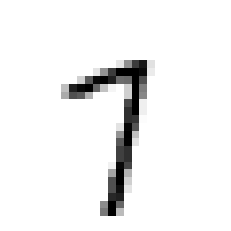

In [110]:
x_batch, y_batch = train_ds[0:100]
plot_digit(x_batch[42])

In [111]:
from torch import optim

model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
optimizer = optim.SGD(model.parameters(), lr=lr)

In [112]:
def fit(epochs=1):
    for _ in range(epochs):
        for i in range((n-1)//batch_size + 1):
            x_batch, y_batch = train_ds[i*batch_size : i*batch_size+batch_size]
            predictions = model(torch.from_numpy(x_batch))
            loss = F.cross_entropy(predictions, torch.from_numpy(y_batch))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [113]:
fit()
F.cross_entropy(torch.from_numpy(x_batch), torch.from_numpy(y_batch)), accuracy(model(torch.from_numpy(x_batch)), torch.from_numpy(y_batch))

(tensor(6.8455), tensor(0.9600))

In [114]:
class DataLoader():
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
    def __iter__(self):
        for i in range(0, len(self.dataset), self.batch_size):
            yield self.dataset[i:i+self.batch_size]

In [115]:
train_dl = DataLoader(train_ds, batch_size)
valid_dl = DataLoader(valid_ds, batch_size)

In [116]:
def fit(epochs=1):
    for _ in range(epochs):
        for x_batch, y_batch in train_dl:
            predictions = model(torch.from_numpy(x_batch))
            loss = F.cross_entropy(predictions, torch.from_numpy(y_batch))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [117]:
fit()
F.cross_entropy(torch.from_numpy(x_batch), torch.from_numpy(y_batch)), accuracy(model(torch.from_numpy(x_batch)), torch.from_numpy(y_batch))

(tensor(6.8455), tensor(0.9400))

PyTorch has its own `DataLoader` and has a `RandomSampler`/`Seq

In [118]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [119]:
train_dl = DataLoader(train_ds, batch_size, sampler=RandomSampler(train_ds))
valid_dl = DataLoader(valid_ds, batch_size, sampler=SequentialSampler(valid_ds))

In [120]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
optimizer = optim.SGD(model.parameters(), lr=lr)

In [121]:
def fit(epochs=1):
    for _ in range(epochs):
        for x_batch, y_batch in train_dl:
            predictions = model(x_batch)
            loss = F.cross_entropy(predictions, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [122]:
fit()
F.cross_entropy(torch.from_numpy(x_batch), torch.from_numpy(y_batch)), accuracy(model(torch.from_numpy(x_batch)), torch.from_numpy(y_batch))

(tensor(6.8455), tensor(0.9800))

### Validation and Training Loop

In [123]:
def fit(epochs, model, loss_func, optimizer, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
#         print(model.training)
        
        for x_batch, y_batch in train_dl:
            loss = loss_func(model(x_batch), y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        model.eval()
#         print(model.training)
        
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for x_batch, y_batch in valid_dl:
                predictions = model(x_batch)
                tot_loss += loss_func(predictions, y_batch)
                tot_acc += accuracy(predictions, y_batch)
        
        print(epoch, tot_loss/len(valid_dl), tot_acc/len(valid_dl))
        
    return tot_loss/len(valid_dl), tot_acc/len(valid_dl)

In [124]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
optimizer = optim.SGD(model.parameters(), lr=lr)

In [125]:
%time loss, acc = fit(epochs=10, model=model, loss_func=F.cross_entropy, optimizer=optimizer, train_dl=train_dl, valid_dl=valid_dl)

0 tensor(0.1752) tensor(0.9494)
1 tensor(0.1443) tensor(0.9558)
2 tensor(0.1409) tensor(0.9571)
3 tensor(0.1430) tensor(0.9579)
4 tensor(0.0966) tensor(0.9710)
5 tensor(0.1053) tensor(0.9702)
6 tensor(0.1113) tensor(0.9690)
7 tensor(0.1044) tensor(0.9719)
8 tensor(0.1999) tensor(0.9492)
9 tensor(0.1036) tensor(0.9708)
CPU times: user 17.6 s, sys: 88.5 ms, total: 17.7 s
Wall time: 8.84 s
